# Pre-processing

In [3]:
import pandas

file_path = '/mnt/data/global_air_pollution_data.csv'
data = pandas.read_csv('global_air_pollution_data.csv')
data.head(), data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23463 entries, 0 to 23462
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   country_name        23036 non-null  object
 1   city_name           23462 non-null  object
 2   aqi_value           23463 non-null  int64 
 3   aqi_category        23463 non-null  object
 4   co_aqi_value	       23463 non-null  int64 
 5   co_aqi_category     23463 non-null  object
 6   ozone_aqi_value     23463 non-null  int64 
 7   ozone_aqi_category  23463 non-null  object
 8   no2_aqi_value       23463 non-null  int64 
 9   no2_aqi_category    23463 non-null  object
 10  pm2.5_aqi_value     23463 non-null  int64 
 11  pm2.5_aqi_category  23463 non-null  object
dtypes: int64(5), object(7)
memory usage: 2.1+ MB


(         country_name         city_name  aqi_value aqi_category  \
 0  Russian Federation        Praskoveya         51     Moderate   
 1              Brazil  Presidente Dutra         41         Good   
 2               Italy   Priolo Gargallo         66     Moderate   
 3              Poland         Przasnysz         34         Good   
 4              France          Punaauia         22         Good   
 
    co_aqi_value\t co_aqi_category  ozone_aqi_value ozone_aqi_category  \
 0               1            Good               36               Good   
 1               1            Good                5               Good   
 2               1            Good               39               Good   
 3               1            Good               34               Good   
 4               0            Good               22               Good   
 
    no2_aqi_value no2_aqi_category  pm2.5_aqi_value pm2.5_aqi_category  
 0              0             Good               51           Moderate 

In [4]:
# have to correct a formatting issue first
data.rename(columns={"co_aqi_value\t": "co_aqi_value"}, inplace=True)
data.columns

Index(['country_name', 'city_name', 'aqi_value', 'aqi_category',
       'co_aqi_value', 'co_aqi_category', 'ozone_aqi_value',
       'ozone_aqi_category', 'no2_aqi_value', 'no2_aqi_category',
       'pm2.5_aqi_value', 'pm2.5_aqi_category'],
      dtype='object')

In [5]:
missing_values = data.isnull().sum()
data_cleaned = data.dropna(subset=['country_name'])
aqi_columns = ['aqi_value', 'co_aqi_value', 'ozone_aqi_value', 'no2_aqi_value', 'pm2.5_aqi_value']

In [24]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# data_cleaned[aqi_columns] = scaler.fit_transform(data_cleaned[aqi_columns])
data_cleaned.loc[:, aqi_columns] = scaler.fit_transform(data_cleaned[aqi_columns])
# ^^^^ Had to use the ol' GPT to make this horrendous mess unfortunately.
# Very sorry, but the compiler was getting very angry (... with warnings) due to the line above it!

In [11]:
categorical_columns = ['aqi_category', 'co_aqi_category', 'ozone_aqi_category', 'no2_aqi_category', 'pm2.5_aqi_category']
data_encoded = pandas.get_dummies(data_cleaned, columns=categorical_columns, drop_first=True)

In [12]:
outliers = data_cleaned[aqi_columns].describe(percentiles=[0.01, 0.99])

In [14]:
numeric_features = [
    'aqi_value', 
    'co_aqi_value', 
    'ozone_aqi_value', 
    'no2_aqi_value', 
    'pm2.5_aqi_value'
]

data_for_clustering = data_encoded[numeric_features]
data_for_clustering.info()
data_for_clustering = data_for_clustering.dropna()
data_for_clustering.head()

<class 'pandas.core.frame.DataFrame'>
Index: 23036 entries, 0 to 23462
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   aqi_value        23036 non-null  float64
 1   co_aqi_value     23036 non-null  float64
 2   ozone_aqi_value  23036 non-null  float64
 3   no2_aqi_value    23036 non-null  float64
 4   pm2.5_aqi_value  23036 non-null  float64
dtypes: float64(5)
memory usage: 1.1 MB


,aqi_value,co_aqi_value,ozone_aqi_value,no2_aqi_value,pm2.5_aqi_value
0,0.091093,0.007519,0.153191,0.000000,0.102
1,0.070850,0.007519,0.021277,0.010989,0.082
2,0.121457,0.007519,0.165957,0.021978,0.132
3,0.056680,0.007519,0.144681,0.000000,0.040
4,0.032389,0.000000,0.093617,0.000000,0.012


# Clustering

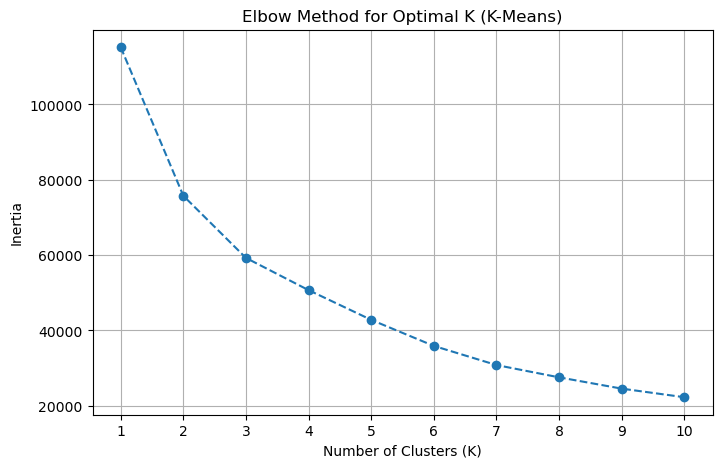

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as pp

# (gotta filter the data to only include the numeric features)
numeric_features = [
    'aqi_value', 
    'co_aqi_value', 
    'ozone_aqi_value', 
    'no2_aqi_value', 
    'pm2.5_aqi_value'
]
data_numeric = data_encoded[numeric_features]

# missing vals
data_numeric = data_numeric.dropna()

# standardize data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_numeric)

inertia = []
cluster_range = range(1, 11)

for i in cluster_range:
    kmeans = KMeans(n_clusters=i, n_init=10)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)

pp.figure(figsize=(8, 5))
pp.plot(cluster_range, inertia, marker='o', linestyle='--')
pp.title("Elbow Method for Optimal K (K-Means)")
pp.xlabel("Number of Clusters (K)")
pp.ylabel("Inertia")
pp.xticks(cluster_range)
pp.grid()
pp.show()